# GNN Benchmarking Project Overview

This project benchmarks and compares three popular Graph Neural Networks (GNNs): **GCN (Graph Convolutional Network)**, **GraphSAGE (Graph Sample and Aggregation)**, and **GAT (Graph Attention Network)**. The goal of this project is to evaluate these models' performance on graph-based data, particularly image graphs transformed into graph representations.

## Table of Contents
- [Introduction](#introduction)
- [Models](#models)
  - [GCN](#gcn)
  - [GraphSAGE](#graphsage)
  - [GAT](#gat)
- [Benchmarking Setup](#benchmarking-setup)
- [Results](#results)
- [Conclusion](#conclusion)

## Introduction

Graph Neural Networks (GNNs) are a powerful class of deep learning models designed to handle graph-structured data. GNNs have seen wide application in fields such as **social networks**, **recommendation systems**, **biology (protein interaction networks)**, and **natural language processing**. This project benchmarks three different types of GNNs to evaluate their performance on a specific graph dataset, such as a graphified image dataset.

## Models

### 1. GCN (Graph Convolutional Network)

#### Overview
GCN is one of the foundational models in the GNN family. The core idea of a GCN is to perform **convolution** operations on a graph, where each node aggregates information from its neighbors to update its feature vector.

#### How It Works
- In GCN, a node's new feature representation is obtained by aggregating the features of its neighbors.
- The aggregation is done using a **weighted sum**, followed by a **non-linear activation function** (such as ReLU).
- The graph's structure is captured by the **normalized adjacency matrix**.

#### Formula:
The core update rule in GCN is:

$$
\mathbf{H}^{(l+1)} = \sigma(\hat{\mathbf{A}} \mathbf{H}^{(l)} \mathbf{W}^{(l)})
$$
Where:
- $\hat{\mathbf{A}}$ is the normalized adjacency matrix.
- $\mathbf{H}^{(l)}$ is the matrix of node features at layer $l$.
- $\mathbf{W}^{(l)}$ is the learnable weight matrix at layer $l$.
- $\sigma$ is the activation function (usually ReLU).


#### Use Case
- GCNs work well for graphs with **small to medium-sized nodes**, where the graph is not too large or sparse.

### 2. GraphSAGE (Graph Sample and Aggregation)

#### Overview
GraphSAGE improves upon GCNs by introducing **neighbor sampling** to deal with large graphs. Instead of using all neighbors for aggregation, GraphSAGE samples a fixed-size set of neighbors and aggregates their features.

#### How It Works
- In GraphSAGE, each node samples a fixed number of neighbors (instead of aggregating all neighbors).
- It supports **multiple aggregation functions** like **mean**, **LSTM-based**, and **pooling**, offering flexibility in how information is aggregated.
- The node's new feature representation is obtained by **combining** its own features with the aggregated features of the sampled neighbors.

#### Formula:
$$
\mathbf{h}_v' = \sigma \left( \mathbf{W} \cdot \text{AGGREGATE} \left( \{\mathbf{h}_u: u \in \mathcal{N}(v)\} \right) + \mathbf{b} \right)
$$
Where:
- $\mathcal{N}(v)$ is the set of neighbors of node $v$.
- $\text{AGGREGATE}$ is the aggregation function (e.g., mean, LSTM).
- $\mathbf{h}_v'$ is the updated feature vector for node $v$.

#### Use Case
- GraphSAGE is ideal for **large-scale graphs** like social networks or **dynamic graphs** where the graph structure changes over time.

### 3. GAT (Graph Attention Network)

#### Overview
GAT introduces the **attention mechanism** to GNNs. Instead of aggregating all neighbors equally, GAT assigns **learned attention scores** to each neighbor, allowing the model to focus more on important neighbors.

#### How It Works
- Each node computes **attention scores** for each of its neighbors, indicating how much attention should be paid to each neighbor's features.
- The updated feature representation is then computed as a weighted sum of the neighbors' features, where the weights are determined by the attention mechanism.

#### Formula:
The update rule in GAT is:
$$
\mathbf{h}_v' = \sigma \left( \sum_{u \in \mathcal{N}(v)} \alpha_{vu} \cdot \mathbf{W} \mathbf{h}_u \right)
$$
Where:
- $\alpha_{vu}$ is the attention coefficient between nodes $v$ and $u$.
- $\mathbf{W}$ is the learnable weight matrix.
- $\mathcal{N}(v)$ is the set of neighbors of node $v$.

#### Attention Computation:
The attention coefficients \(\alpha_{vu}\) are computed as:
$$
\alpha_{vu} = \text{softmax} \left( \text{LeakyReLU} \left( \mathbf{a}^\top [\mathbf{W} \mathbf{h}_v || \mathbf{W} \mathbf{h}_u] \right) \right)
$$
Where:
- $\mathbf{a}$ is the learnable attention vector.
- $||$ denotes the concatenation of feature vectors.

#### Use Case
- GATs are useful when **neighbor importance varies** and we want to learn which neighbors are most important for each node.
- Applications like **social network analysis**, **recommendation systems**, and **NLP tasks** benefit from GATs.

## Benchmarking Setup

This project benchmarks the performance of **GCN**, **GraphSAGE**, and **GAT** on a graphified dataset derived from images (such as superpixels). The dataset is split into training and validation sets, and the models are trained using standard training loops. For each model, the following metrics are tracked:

- **Training Loss**
- **Validation Accuracy**
- **Epoch Time**
- **Model Size (Parameters)**

The models are evaluated over a specified number of epochs, and the results are plotted in **learning curves** and a **final comparison** that shows:

- Final validation accuracy
- Average epoch time
- Model size (parameters)

## Results

After training the models for a fixed number of epochs, the results are summarized in the following ways:

- **Learning Curves**: These curves show the evolution of the validation accuracy over time for each model.
- **Final Comparison**: A bar plot that compares the final validation accuracy, average epoch time, and number of parameters for each model.

## Conclusion

This benchmarking project allows us to compare the performance of three important GNN models (GCN, GraphSAGE, GAT) on graph-based datasets. By evaluating their accuracy, training time, and model size, we gain insights into which model is best suited for different types of graph tasks and datasets.


In [1]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from skimage.segmentation import slic
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = 'data'
IMAGE_SIZE = 224
BATCH_SIZE = 16
N_SEGMENTS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 100

In [3]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

train_idx, val_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,
    stratify=[dataset[i][1] for i in range(len(dataset))],
    random_state=42
)

In [4]:
def image_to_graph(image, label, n_segments=N_SEGMENTS):
    image_np = image.permute(1, 2, 0).cpu().numpy()
    segments = slic(image_np, n_segments=n_segments, compactness=10, start_label=0)
    segment_ids = np.unique(segments)

    features = []
    for seg_id in segment_ids:
        mask = segments == seg_id
        mean_color = image_np[mask].mean(axis=0)
        features.append(mean_color)
    x = torch.tensor(features, dtype=torch.float)

    edge_index = []
    for i in range(segments.shape[0]):
        for j in range(segments.shape[1]):
            current = segments[i, j]
            neighbors = []
            if i > 0: neighbors.append(segments[i-1, j])
            if i < segments.shape[0]-1: neighbors.append(segments[i+1, j])
            if j > 0: neighbors.append(segments[i, j-1])
            if j < segments.shape[1]-1: neighbors.append(segments[i, j+1])
            for n in neighbors:
                if current != n:
                    edge_index.append([current, n])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

In [5]:
def prepare_graph_dataset(indices):
    graph_data = []
    for idx in tqdm(indices):
        img, label = dataset[idx]
        graph_data.append(image_to_graph(img, label))
    return graph_data

In [6]:
class GNN(torch.nn.Module):
    def __init__(self, model_type, in_channels, hidden_channels, num_classes, num_layers=4):
        super().__init__()
        Conv = {'GCN': GCNConv, 'SAGE': SAGEConv, 'GAT': GATConv}[model_type]
        
        self.convs = torch.nn.ModuleList()
        self.convs.append(Conv(in_channels, hidden_channels))
        
        for _ in range(num_layers - 1):
            self.convs.append(Conv(hidden_channels, hidden_channels))

        self.lin = torch.nn.Linear(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)

        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

In [7]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(DEVICE)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

In [8]:
def plot_learning_curves(val_accs, model_type):
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(val_accs)+1), val_accs, marker='o', label='Validation Accuracy')
    plt.title(f'{model_type} Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

In [9]:
def plot_final_comparison(results):
    model_types = list(results.keys())
    val_accs = [results[m]['final_val_acc'] for m in model_types]
    params = [results[m]['params'] // 1000 for m in model_types]  # in K
    times = [results[m]['avg_epoch_time'] for m in model_types]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Validation Accuracy Bar Plot
    axs[0].bar(model_types, val_accs, color=['skyblue', 'lightgreen', 'salmon'])
    axs[0].set_title('Final Validation Accuracy')
    axs[0].set_ylim(0, 1)
    axs[0].set_ylabel('Accuracy')

    # Model Size Bar Plot
    axs[1].bar(model_types, params, color=['skyblue', 'lightgreen', 'salmon'])
    axs[1].set_title('Model Parameters (K)')
    axs[1].set_ylabel('Params (x1000)')

    # Time per Epoch Bar Plot
    axs[2].bar(model_types, times, color=['skyblue', 'lightgreen', 'salmon'])
    axs[2].set_title('Average Time per Epoch (s)')
    axs[2].set_ylabel('Seconds')

    plt.suptitle('GNN Benchmark Comparison', fontsize=16)
    plt.show()

Preparing Graph Datasets...


  0%|          | 0/1716 [00:00<?, ?it/s]

/var/folders/vs/t5fdjjyn3k1_3w3y7btpmndc0000gn/T/ipykernel_19742/2325350412.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  x = torch.tensor(features, dtype=torch.float)
100%|██████████| 429/429 [00:27<00:00, 15.65it/s]
/opt/homebrew/Caskroom/miniconda/base/envs/tf-env/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Benchmarking GCN...
Epoch 1/100, Loss: 1.3407, Val Acc: 0.4196, Time: 18.77s
Epoch 2/100, Loss: 1.1275, Val Acc: 0.5268, Time: 18.65s
Epoch 3/100, Loss: 1.0591, Val Acc: 0.5268, Time: 18.29s
Epoch 4/100, Loss: 1.0460, Val Acc: 0.5291, Time: 18.62s
Epoch 5/100, Loss: 1.0259, Val Acc: 0.5152, Time: 18.36s
Epoch 6/100, Loss: 1.0247, Val Acc: 0.5361, Time: 18.54s
Epoch 7/100, Loss: 1.0299, Val Acc: 0.5455, Time: 19.22s
Epoch 8/100, Loss: 1.0225, Val Acc: 0.5548, Time: 18.96s
Epoch 9/100, Loss: 1.0340, Val Acc: 0.5245, Time: 18.57s
Epoch 10/100, Loss: 1.0147, Val Acc: 0.5291, Time: 20.24s
Epoch 11/100, Loss: 1.0190, Val Acc: 0.5198, Time: 18.57s
Epoch 12/100, Loss: 1.0184, Val Acc: 0.5361, Time: 19.04s
Epoch 13/100, Loss: 1.0227, Val Acc: 0.5385, Time: 18.53s
Epoch 14/100, Loss: 1.0123, Val Acc: 0.5594, Time: 19.26s
Epoch 15/100, Loss: 1.0146, Val Acc: 0.5431, Time: 18.74s
Epoch 16/100, Loss: 1.0183, Val Acc: 0.5478, Time: 18.49s
Epoch 17/100, Loss: 1.0008, Val Acc: 0.5455, Time: 18.99s
Ep

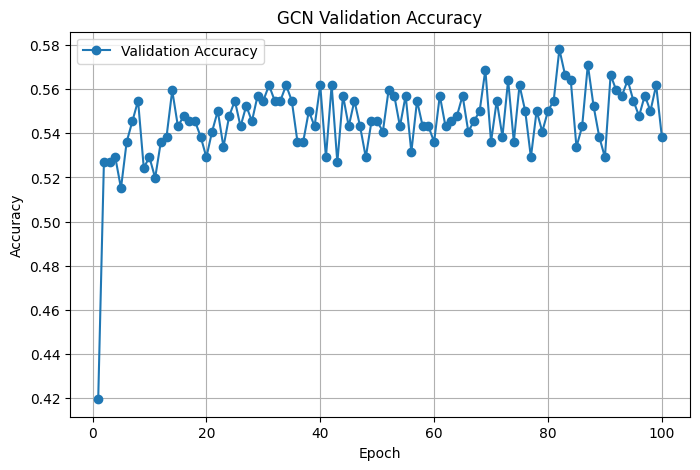


Benchmarking SAGE...
Epoch 1/100, Loss: 1.2144, Val Acc: 0.5268, Time: 11.73s
Epoch 2/100, Loss: 1.0274, Val Acc: 0.5571, Time: 11.93s
Epoch 3/100, Loss: 0.9960, Val Acc: 0.5455, Time: 11.64s
Epoch 4/100, Loss: 0.9873, Val Acc: 0.5571, Time: 11.60s
Epoch 5/100, Loss: 0.9870, Val Acc: 0.5641, Time: 11.54s
Epoch 6/100, Loss: 0.9783, Val Acc: 0.5501, Time: 11.54s
Epoch 7/100, Loss: 0.9647, Val Acc: 0.5548, Time: 11.53s
Epoch 8/100, Loss: 0.9479, Val Acc: 0.5711, Time: 11.59s
Epoch 9/100, Loss: 0.9572, Val Acc: 0.6061, Time: 11.54s
Epoch 10/100, Loss: 0.9438, Val Acc: 0.6317, Time: 11.57s
Epoch 11/100, Loss: 0.9349, Val Acc: 0.5967, Time: 11.53s
Epoch 12/100, Loss: 0.9167, Val Acc: 0.6434, Time: 11.65s
Epoch 13/100, Loss: 0.9047, Val Acc: 0.6457, Time: 11.57s
Epoch 14/100, Loss: 0.8880, Val Acc: 0.6037, Time: 11.54s
Epoch 15/100, Loss: 0.8786, Val Acc: 0.6061, Time: 11.51s
Epoch 16/100, Loss: 0.8579, Val Acc: 0.6713, Time: 11.54s
Epoch 17/100, Loss: 0.8193, Val Acc: 0.6643, Time: 11.55s
E

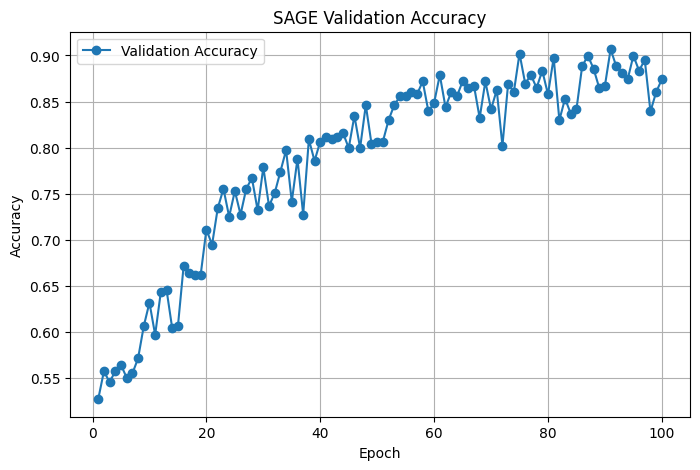


Benchmarking GAT...
Epoch 1/100, Loss: 1.2713, Val Acc: 0.4988, Time: 22.78s
Epoch 2/100, Loss: 1.0454, Val Acc: 0.5548, Time: 22.82s
Epoch 3/100, Loss: 1.0126, Val Acc: 0.5501, Time: 22.61s
Epoch 4/100, Loss: 1.0047, Val Acc: 0.5501, Time: 22.57s
Epoch 5/100, Loss: 0.9929, Val Acc: 0.5594, Time: 22.61s
Epoch 6/100, Loss: 0.9920, Val Acc: 0.5501, Time: 23.25s
Epoch 7/100, Loss: 0.9838, Val Acc: 0.5478, Time: 22.69s
Epoch 8/100, Loss: 0.9759, Val Acc: 0.5291, Time: 22.72s
Epoch 9/100, Loss: 0.9939, Val Acc: 0.5431, Time: 22.75s
Epoch 10/100, Loss: 0.9832, Val Acc: 0.5571, Time: 22.75s
Epoch 11/100, Loss: 0.9744, Val Acc: 0.5548, Time: 22.65s
Epoch 12/100, Loss: 0.9682, Val Acc: 0.5408, Time: 22.64s
Epoch 13/100, Loss: 0.9713, Val Acc: 0.5548, Time: 22.69s
Epoch 14/100, Loss: 0.9680, Val Acc: 0.5734, Time: 22.63s
Epoch 15/100, Loss: 0.9713, Val Acc: 0.5711, Time: 22.70s
Epoch 16/100, Loss: 0.9589, Val Acc: 0.5548, Time: 23.14s
Epoch 17/100, Loss: 0.9602, Val Acc: 0.5758, Time: 22.95s
Ep

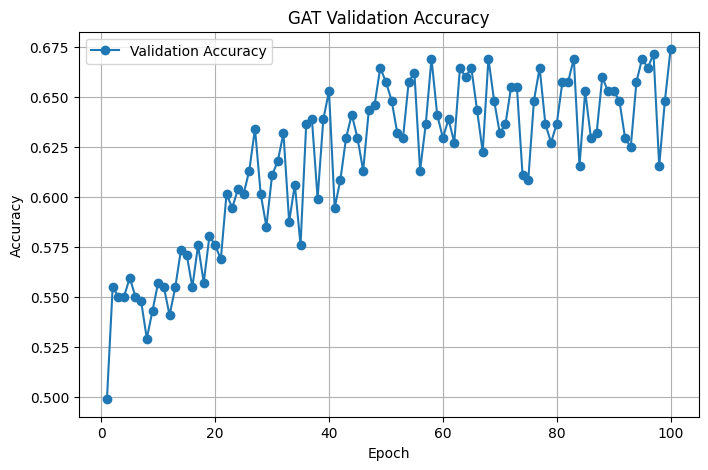

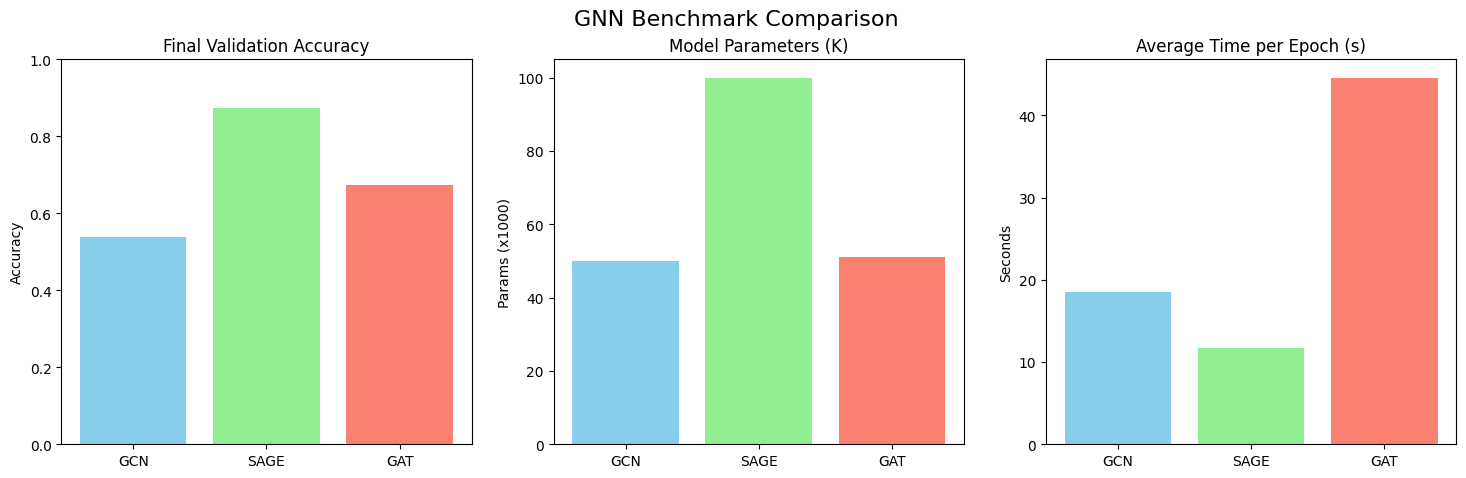


Benchmark Summary:
GCN: Val Acc=0.5385, Params=50K, Time/Epoch=18.58s
SAGE: Val Acc=0.8741, Params=100K, Time/Epoch=11.67s
GAT: Val Acc=0.6737, Params=51K, Time/Epoch=44.60s


In [10]:
if __name__ == '__main__':
    print("Preparing Graph Datasets...")
    train_data = prepare_graph_dataset(train_idx)
    val_data = prepare_graph_dataset(val_idx)

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

    results = {}

    for model_type in ['GCN', 'SAGE', 'GAT']:
        print(f"\nBenchmarking {model_type}...")
        model = GNN(model_type, in_channels=3, hidden_channels=128, num_classes=num_classes).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

        epoch_times = []
        train_accs = []
        val_accs = []

        for epoch in range(EPOCHS):
            start_time = time.time()
            loss = train(model, train_loader, optimizer)
            val_acc = evaluate(model, val_loader)
            epoch_time = time.time() - start_time

            epoch_times.append(epoch_time)
            val_accs.append(val_acc)

            print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")
        
        plot_learning_curves(val_accs, model_type)

        results[model_type] = {
            'final_val_acc': val_accs[-1],
            'avg_epoch_time': np.mean(epoch_times),
            'params': sum(p.numel() for p in model.parameters())
        }
    plot_final_comparison(results)
    print("\nBenchmark Summary:")
    for model_type, info in results.items():
        print(f"{model_type}: Val Acc={info['final_val_acc']:.4f}, Params={info['params']//1000}K, Time/Epoch={info['avg_epoch_time']:.2f}s")
